# WCT Analysis

Whistle Contour Types (WCT) analysis. 

Exploration of the categories produced by ARTwarp and manual verifications

## Importations

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from WCT_analysis_utils import (run_SIGID, plot_wct_grid, compact_letter_display,
    vertical_proportion_plot, horizontal_proportion_plot, categories_multi_dates, 
    get_stars, fisher_tests)

path_audio_folder = "/media/loic/DOLPHINFREE/Datasets/DOLPHINFREE/Acoustique"

In [2]:
results_df = pd.read_csv(
    "./resources/dtw_resources/contours_with_category.csv",
    index_col=0, parse_dates=["start_dt", "stop_dt"])   
results_df["date"] = pd.to_datetime(results_df["start_dt"].dt.date)
results_df["year"] = results_df["date"].dt.year
results_df["clean_activation_state"] = results_df["activation_state"].copy()
results_df.loc[results_df.clean_activation_state == 'Control', 'clean_activation_state'] = "BEF"

# rename isolated whistles to -1 (singletons)
cat_counts = np.unique(results_df.category, return_counts=True)
for cat, count in zip(cat_counts[0], cat_counts[1]):
    if cat == 0:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1
    elif count == 1:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1

## SIGID

A method for the IDentification of SIGnature whistles (SIGID) developped by [Janik et al. 2013](https://onlinelibrary.wiley.com/doi/10.1111/j.1748-7692.2011.00549.x).

It relies on the analysis of WCTs: if 75% or more of the whistles of a WCT are within 1-10s of another similar whistle, then this WCT can be considered to be a SWT (Signature Whistles Type).

In [Fearey et al. 2019](http://link.springer.com/10.1007/s10071-019-01274-1), the authors consider a time-window of 0.2-10s for their study on common dolphins. As we are also working with *D.delphis*, let's compare these intervals.

### SWT identification

Identification of SWTs among the WCTs

In [3]:
intervals_to_try = [(0.2, 10), (1, 10)] # min and max for each time-window

In [4]:
# Identify SWTs (SIGID method)
for interval in tqdm(intervals_to_try, desc="SIGID interval", leave=True, position=0):
    results_df = run_SIGID(results_df, interval=interval)

# Difference in the number of SWT identified
results_df["SWT_difference"] = (
    results_df[f"SWT_[{intervals_to_try[0][0]},{intervals_to_try[0][1]}]"] !=
    results_df[f"SWT_[{intervals_to_try[1][0]},{intervals_to_try[1][1]}]"]
)
mismatch_whistles = results_df['SWT_difference'].sum()
mismatch_category = ((results_df.groupby('category')["SWT_difference"].sum()) > 1).sum()

print(f"\nDifferent intervals: {mismatch_category} mismatched SWTs (or {mismatch_whistles} SWs)")


SIGID interval: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Different intervals: 6 mismatched SWTs (or 50 SWs)


### Choosing SIGID interval

So using the original interval of [1, 10] sec we get different results than if we use the [0.2, 10] sec interval.

Which categories are classified differently?

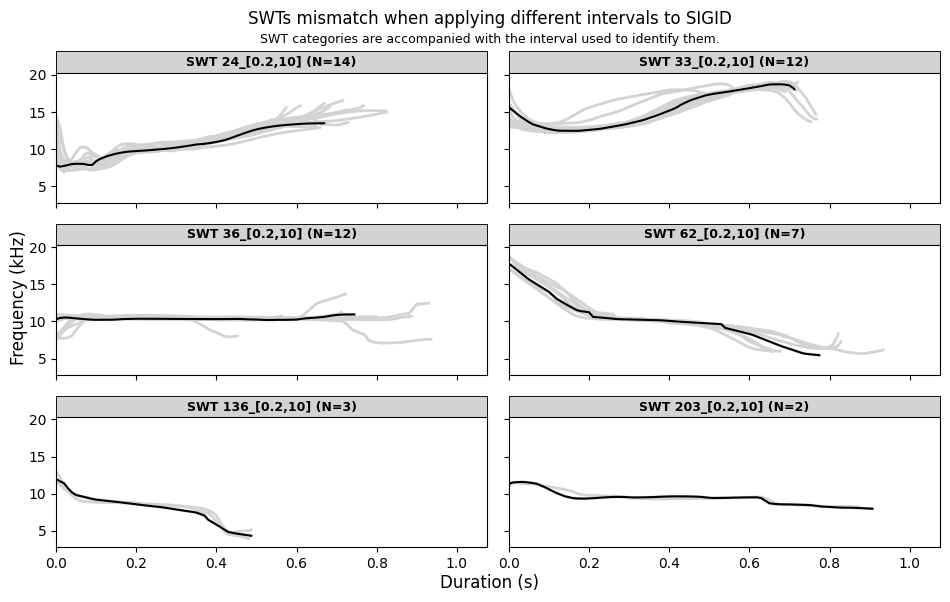

In [5]:
mismatch_df = results_df[results_df["SWT_difference"]].copy()
for id_row, row in mismatch_df.iterrows():
    if row["SWT_[1,10]"]:
        mismatch_df.loc[id_row, "category"] = str(row["category"])+"_[1,10]"
    else:
        mismatch_df.loc[id_row, "category"] = str(row["category"])+"_[0.2,10]"

misfig, misaxs = plot_wct_grid(mismatch_df, name="SWT ", rename=False)
misfig.suptitle("SWTs mismatch when applying different intervals to SIGID")
misfig.text(
    0.5, 0.925,
    "SWT categories are accompanied with the interval used to identify them.",
    ha="center", fontsize=9)
misfig.subplots_adjust(bottom=0.085, top=0.875)
misfig.set_size_inches(10, 6)
misfig.savefig("/home/loic/Pictures/CDD/SWTs_interval_mismatch.pdf")
plt.show()

Ok, so all the additional SWTs come from the selection of WCTs using the [0.2, 10] sec interval.

Since, this interval was specifically create for *D. delphis* whistle, we keep this interval for further analyses.

In [6]:
the_interval = "SWT_[0.2,10]"
print(f"Choosing interval: {the_interval}")
results_df['is_SW'] = results_df[the_interval].astype(int)

Choosing interval: SWT_[0.2,10]


## SWT data summary
### Overview

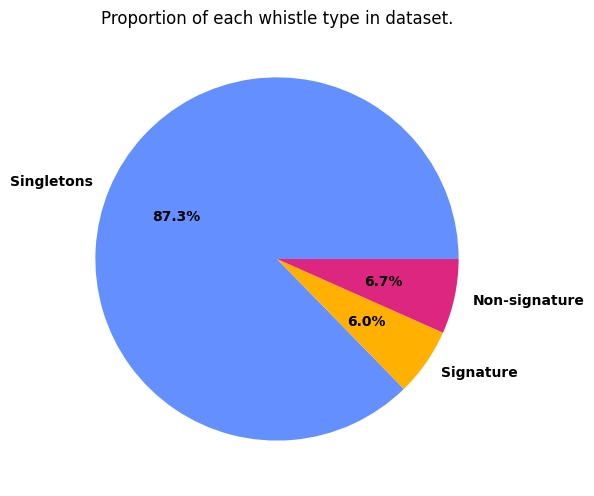

In [7]:
pie_fig, pie_axs = plt.subplots(1, 1, figsize=(6,6))
pie_axs.pie(
    x=[
        100*len(results_df[results_df.category == -1])/len(results_df),
        100*len(results_df[results_df["is_SW"] == 1])/len(results_df),
        100*len(results_df[(results_df["is_SW"] == 0) & (results_df.category != -1)])/len(results_df)
        ],
    labels=["Singletons", "Signature", "Non-signature"],
    colors=["#648fff", "#ffb000", "#dc267f"],
    autopct="%1.1f%%",
    textprops=dict(weight='bold')
)
pie_axs.set_title("Proportion of each whistle type in dataset.")
pie_fig.tight_layout()
pie_fig.savefig("/home/loic/Pictures/CDD/pie_chart.pdf")
plt.show()

In [8]:
print(f"Mean duration (WCTs): {results_df[results_df.category != -1].duration.mean():.2f} (SD: {results_df[results_df.category != -1].duration.std():.2f})")
print(f"Mean duration (singletons): {results_df[results_df.category == -1].duration.mean():.2f} (SD: {results_df[results_df.category == -1].duration.std():.2f})")

Mean duration (WCTs): 0.88 (SD: 0.33)
Mean duration (singletons): 0.52 (SD: 0.35)


In [9]:
print("\nAmong all whistles:")
print(f"\tNSWTs represent {100*results_df[(results_df['is_SW'] == 0) & (results_df['category'] != -1)].category.nunique()/(results_df.category.nunique()-1):.2f}% of WCTs ({results_df[(results_df['is_SW'] == 0) &(results_df['category'] != -1)].category.nunique()}/{results_df.category.nunique()-1}).")
print(f"\tSWTs represent {100*results_df[results_df[the_interval]].category.nunique()/(results_df.category.nunique()-1):.2f}% of WCTs ({results_df[results_df[the_interval]].category.nunique()}/{results_df.category.nunique()-1}).")
print(f"\tNSWs represent {100*len(results_df[(results_df['is_SW'] == 0) & (results_df['category'] != -1)])/len(results_df):.2f}% of whistles ({len(results_df[(results_df['is_SW'] == 0) & (results_df['category'] != -1)])}/{len(results_df)}).")
print(f"\tSWs represent {100*results_df[the_interval].sum()/len(results_df):.2f}% of whistles ({results_df[the_interval].sum()}/{len(results_df)}).")



Among all whistles:
	NSWTs represent 62.50% of WCTs (135/216).
	SWTs represent 37.50% of WCTs (81/216).
	NSWs represent 6.65% of whistles (770/11575).
	SWs represent 6.04% of whistles (699/11575).


In [10]:
print(f"# whistles per WCT: {results_df[results_df.category != -1].groupby('category').size().mean():.2f} (SD: {results_df[results_df.category != -1].groupby('category').size().std():.2f})")
print(f"# whistles per SWT: {results_df[results_df['is_SW'] == 1].groupby('category').size().mean():.2f} (SD: {results_df[results_df['is_SW'] == 1].groupby('category').size().std():.2f})")

# whistles per WCT: 6.80 (SD: 6.62)
# whistles per SWT: 8.63 (SD: 7.15)


In [11]:
# What about the ID of each group of dolphin ?
group_ID_datetime = pd.read_csv(
    "./resources/DF-whistles/group_ID_datetime.csv", 
    parse_dates=["datetime_utc"])
results_df["ID_group"] = None

for row_id, row in tqdm(results_df.iterrows(), total=len(results_df)):
    corr_row = group_ID_datetime[group_ID_datetime["datetime_utc"] <= row["start_dt"]].iloc[-1]
    results_df.loc[row_id, "ID_group"] = corr_row["ID_group"]

100%|██████████| 11575/11575 [00:05<00:00, 2300.40it/s]


In [12]:
# is each WCT or SWT specific to a specific sequence
print(f"Average number of groups associated to a specific WCT: {results_df[results_df.category != -1].groupby('category')['ID_group'].nunique().mean():.2f} (SD: {results_df[results_df.category != -1].groupby('category')['ID_group'].nunique().std():.2f})")
print(f"Average number of groups associated to a specific SWT: {results_df[results_df['is_SW']==1].groupby('category')['ID_group'].nunique().mean():.2f} (SD: {results_df[results_df['is_SW']==1].groupby('category')['ID_group'].nunique().std():.2f})")

Average number of groups associated to a specific WCT: 1.04 (SD: 0.36)
Average number of groups associated to a specific SWT: 1.07 (SD: 0.35)


In [13]:
n_SW_per_file = []
n_SW_per_file_per_dolphin = []
for year in ["2020", "2021", "2022"]:
    for date in os.listdir(os.path.join(path_audio_folder, year)):
        if date.startswith(".") or date.endswith(".txt") or date.endswith(".xlsx"):
            continue
        for file in os.listdir(os.path.join(path_audio_folder, year, date)):
            if file.endswith(".wav") and (not file.startswith(".")):
                table = results_df[
                    ((results_df['is_SW']==1) &
                    (results_df['file']==datetime.strptime(file[8:-4], "%Y%m%d_%H%M%S").strftime("%Y-%m-%d_%H:%M")))
                    ]
                if len(table) >= 1:
                    n_SW_per_file += [len(table)]
                    n_SW_per_file_per_dolphin += [len(table)/table.group_size.iloc[0]]
                else:
                    n_SW_per_file += [0]
                    n_SW_per_file_per_dolphin += [0]

print("SW rate (per minute):", "{:.2f}".format(np.mean(n_SW_per_file)))
print("SW rate (per minute per dolphin):", "{:.2f}".format(np.nanmean(n_SW_per_file_per_dolphin)))

SW rate (per minute): 0.85
SW rate (per minute per dolphin): 0.14


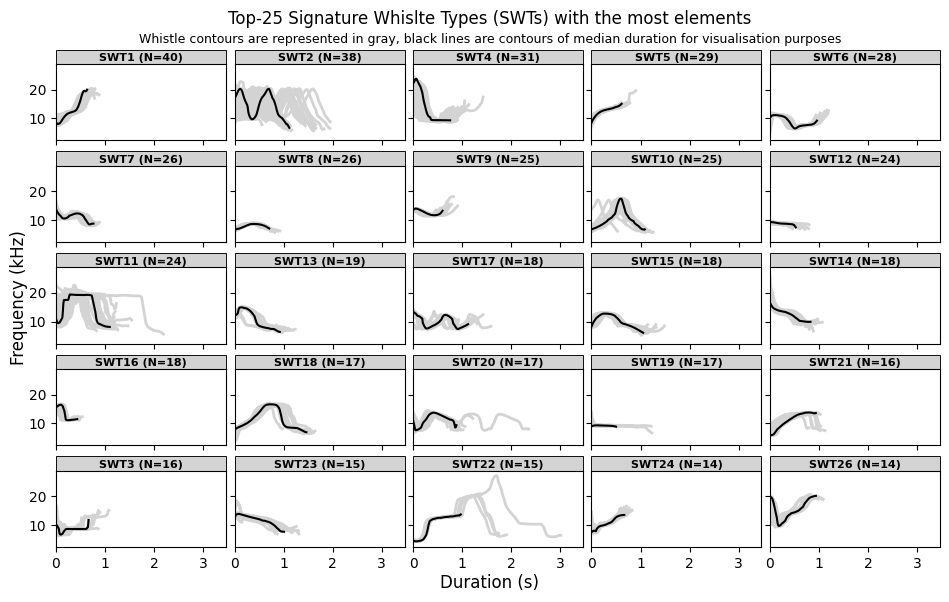

In [14]:
# display best contours
results_df_grouped = results_df.drop(index=results_df[results_df.category==-1].index, inplace=False).copy()
gridfig, gridaxs = plot_wct_grid(
    results_df_grouped, mode="median_dur",
    name="SWT", n_categories=25, rename=False)
gridfig.suptitle("Top-25 Signature Whislte Types (SWTs) with the most elements")
gridfig.text(
    0.5, 0.925,
    "Whistle contours are represented in gray, black lines are contours of median duration for visualisation purposes",
    ha="center", fontsize=9)
gridfig.subplots_adjust(bottom=0.085, top=0.89)
gridfig.set_size_inches(10, 6)
for axs in gridaxs:
    for ax in axs:
        ax.get_children()[-11].set_height(5)
        ax.set_title(
            ax.get_children()[-4].get_text(),
            pad=2, 
            fontsize=8,
            fontweight='bold')
gridfig.savefig("/home/loic/Pictures/CDD/SWTs_25.pdf")
plt.show()

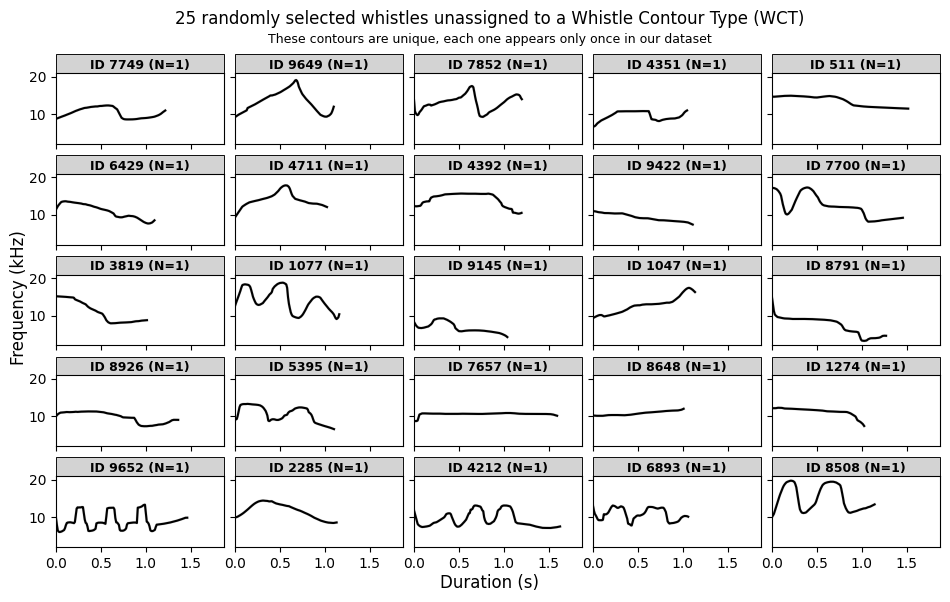

# of singletons: 10106


In [15]:
# display uncategorised contours
singles_df = results_df[results_df.category==-1].copy()
singles_df["category"] = np.arange(len(singles_df), dtype=int)

sinfig, sinaxs = plot_wct_grid(
    singles_df.loc[np.random.RandomState(seed=246).permutation(singles_df[singles_df.duration > 1].index)[:25]], 
    name="ID ", n_categories=25, rename=False)
sinfig.suptitle("25 randomly selected whistles unassigned to a Whistle Contour Type (WCT)")
sinfig.text(
    0.5, 0.925,
    "These contours are unique, each one appears only once in our dataset",
    ha="center", fontsize=9)
sinfig.subplots_adjust(
    bottom=0.085, top=0.875, 
    hspace=0.42, wspace=0.066)
sinfig.set_size_inches(10, 6)
for axs in sinaxs:
    for ax in axs:
        ax.get_children()[-11].set_height(5)
        ax.set_title(
            ax.get_children()[-4].get_text(),
            pad=3, 
            fontsize=9,
            fontweight='bold')
sinfig.savefig("/home/loic/Pictures/CDD/singles_25.pdf")
plt.show()

print("# of singletons:", len(singles_df))

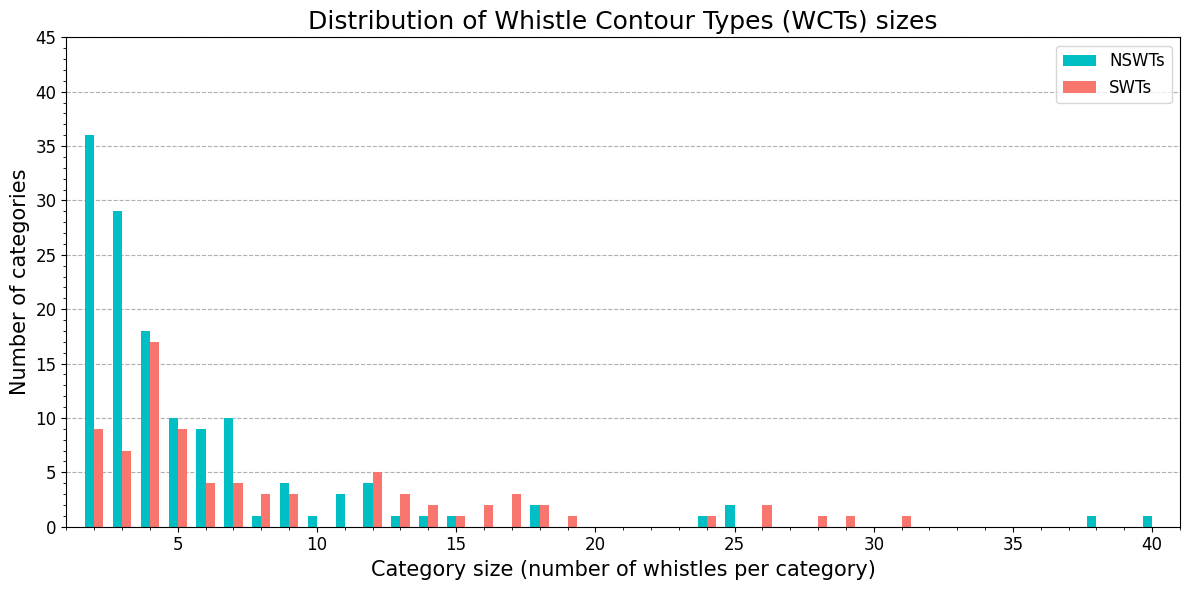

In [16]:
# Distribution plots
wct_no_swt_sizes = results_df[results_df["is_SW"]==0]['category'].value_counts().drop(index=-1)
wct_sizes = results_df['category'].value_counts().drop(index=-1)
swt_sizes = results_df[results_df["is_SW"]==1]['category'].value_counts()

zip_3 = zip(
    [wct_sizes, wct_no_swt_sizes, swt_sizes], 
    ["all WCTs", "NSWTs", "SWTs"],
    ["black", "#00BFC4", "#F8766D"]
    )

zip_2 = zip(
    [wct_no_swt_sizes, swt_sizes], 
    ["NSWTs", "SWTs"],
    ["#00BFC4", "#F8766D"]
    ) 

# Barplot
width = 0.33 # max 0.33
bar_fig, bar_ax = plt.subplots(1, 1, figsize=(12,6))
for i, (size_list, name, color) in enumerate(zip_2):
    
    size_distribution = pd.DataFrame({
        'Category Size': size_list.values,
        'Number of Categories': [1] * len(size_list)
        }).groupby('Category Size')['Number of Categories'].sum().reset_index()
    size_distribution['Category Size'] = pd.to_numeric(size_distribution['Category Size'])

    if i == 0:
        factor = -0.5
    if i == 1:
        factor = 0.5
    if i == 2:
        factor = 1
    bar_ax.bar(
        x=np.array(size_distribution['Category Size'])+factor*width, 
        height=size_distribution['Number of Categories'],
        label=name, width=width, color=color)

    
    # # Fits a power law of distribution ?
    # x = np.linspace(0, 40, 100)
    # shape, loc, scale = stats.pareto.fit(size_list)
    # bar_ax.plot(
    #     x+factor*width, 
    #     max(size_list)*stats.pareto.pdf(x, shape, loc, scale)/max(stats.pareto.pdf(x, shape, loc, scale)), 
    #     '--', label=f"Pareto fitted to {name}", color=color)
    # D, p_value = stats.kstest(size_list, "pareto", args=(shape, loc, scale))
    # print(f"{name} Pareto fit: D={D:.2f} (p={p_value:.2e}, {'Does not fit' if p_value < 0.05 else 'possibly a correct fit'})")


bar_ax.set_title('Distribution of Whistle Contour Types (WCTs) sizes', fontsize=18)
bar_ax.set_xlabel('Category size (number of whistles per category)', fontsize=15)
bar_ax.set_ylabel('Number of categories', fontsize=15)

major_ticks = np.arange(0,46,5)
minor_ticks = np.arange(0,46,1)

bar_ax.set_xticks(major_ticks)
bar_ax.set_xticks(minor_ticks, minor=True)
bar_ax.set_yticks(major_ticks)
bar_ax.set_yticks(minor_ticks, minor=True)

bar_ax.grid(visible=True, which="major", axis='y', linestyle='--', alpha=1)
bar_ax.legend(prop={'size': 12})
bar_ax.set_xlim(1, 41)
bar_ax.tick_params(axis='both', labelsize=12)
bar_ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
bar_fig.tight_layout()
bar_fig.savefig("/home/loic/Pictures/CDD/WCTs_SWTs_distribution.pdf")
plt.show()

## SWT data exploration

Let's investigate if any of the variables that we measured has an effect on the number/proportion of SWTs. Starting with dates.

### Shared SWTs

In [17]:
print(
    categories_multi_dates(results_df, "year").category.nunique(),
    f"WCTs are shared between years.")
print(
    categories_multi_dates(results_df, "date").category.nunique(),
    f"WCTs are shared between days.")
print(
    categories_multi_dates(results_df, "sequence").category.nunique(),
    f"WCTs are shared between sequences.")

6 WCTs are shared between years.
9 WCTs are shared between days.
14 WCTs are shared between sequences.


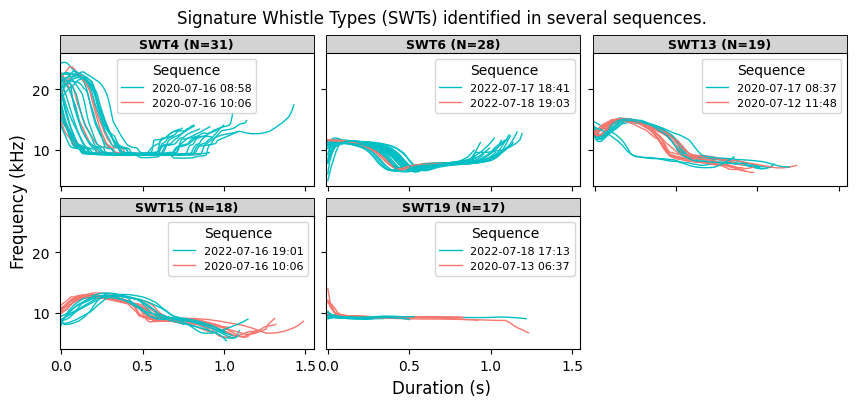

In [18]:
shared_sequence = categories_multi_dates(results_df[results_df[the_interval]], "sequence")
shared_sequence.sort_values(by="category", inplace=True)

colors = ["#00BFC4","#F8766D"]

# plot them per sequence
side_length = [2, 3]
fig, axs = plt.subplots(side_length[0], side_length[1], sharex=True, sharey=True, figsize=(9,4))

# fill in the contours
curr_grid = [0, 0]

for cat_id, cat_name in enumerate(shared_sequence.category.unique()):
    axs[curr_grid[0],curr_grid[1]].set_title(
        f"SWT{cat_name} (N={len(shared_sequence[shared_sequence.category == cat_name])})",
        pad=3.5, 
        fontsize=9,
        fontweight='bold')  
    
    hue_values = {
        value: colors[i%len(colors)] 
        for i, value in 
        enumerate(shared_sequence[shared_sequence.category == cat_name]["sequence"].unique())
    }

    for id_contour, contour in shared_sequence[shared_sequence.category == cat_name].iterrows():
        with open(os.path.join("./resources/DF-whistles/smooth/all", id_contour), "r") as f:
            json_contour = json.load(f)

        axs[curr_grid[0],curr_grid[1]].plot(
            np.array(json_contour["time"])-min(json_contour["time"]),
            np.array(json_contour["frequency"])/1000,
            lw=1, alpha=1,
            color=hue_values[shared_sequence.loc[id_contour, "sequence"]], 
            label=shared_sequence.loc[id_contour, "sequence"]
        )
    
    axs[curr_grid[0],curr_grid[1]].add_patch(
            plt.Rectangle(
                xy=(-0.01, 26), 
                width=1.56, 
                height=3,
                facecolor='lightgray',
                clip_on=False,
                edgecolor="black",
                linewidth = .66))
    
    # make each label unique
    handles, labels = axs[curr_grid[0],curr_grid[1]].get_legend_handles_labels()
    labels = [label.replace("_", " ") for label in labels]
    unique_labels = dict(zip(labels, handles))
    axs[curr_grid[0],curr_grid[1]].legend(
        unique_labels.values(), unique_labels.keys(),
        title="Sequence", prop={"size":8}, fontsize=6)

    if curr_grid[1] >= side_length[1]-1:
        curr_grid[0] += 1
        curr_grid[1] = 0
    else:
        curr_grid[1] += 1


axs[0,0].set_xlim(-0.01,1.55)
axs[0,0].set_ylim(4,26)
fig.supylabel("Frequency (kHz)")
fig.supxlabel("Duration (s)")
fig.delaxes(axs[-1, -1])
fig.suptitle("Signature Whistle Types (SWTs) identified in several sequences.")

fig.subplots_adjust(
    left=0.075, right=0.95,
    bottom=0.13, top=0.87,
    wspace=0.05, hspace=0.225)
fig.savefig("/home/loic/Pictures/CDD/SWTs_shared_sequences.pdf")
plt.show()

These SWTs shared between sequences could have multiple explanations:
- Different groups contained the same 2 individuals, that were not noticed by the observers onboard.
- Contours with very similar shapes, but with fine variations, associated to different but closely related individuals.
- misclassification errors of the ARTwarp algorithm (fine variations are visible, but would need a stricter vigilance value to be differentiated).

Both these hypotheses are plausible. In practice, shared SWTs are very rare in our dataset.

In [19]:
print(
    categories_multi_dates(results_df[results_df[the_interval]], "year").category.nunique(),
    f"SWTs are shared between years.")
print(
    categories_multi_dates(results_df[results_df[the_interval]], "date").category.nunique(),
    f"SWTs are shared between days.")
print(
    categories_multi_dates(results_df[results_df[the_interval]], "sequence").category.nunique(),
    f"SWTs are shared between sequences.")

2 SWTs are shared between years.
4 SWTs are shared between days.
5 SWTs are shared between sequences.


When considering all WCTs, more types are shared between sequences/days. But by definition, these WCTs are not specific to individuals as they are not SWs, so they could be shared by several dolphins and/or groups of dolphins, with various applications that are unknown to this day.

### Average frequency

In [20]:
wct_average_freq = []
swt_average_freq = []

for id_row, row in tqdm(results_df.iterrows(), total=len(results_df)):
    with open(os.path.join("./resources/DF-whistles/smooth/all", id_row)) as f:
        coords = json.load(f)

    x = np.array(coords["time"])
    y = np.array(coords["frequency"])
    y = y[np.argsort(x)]

    # Mean Frequency 
    if row["is_SW"] == 1:
        swt_average_freq += [np.mean(y)/1000]
    else:
        wct_average_freq += [np.mean(y)/1000]

100%|██████████| 11575/11575 [00:01<00:00, 7190.72it/s]


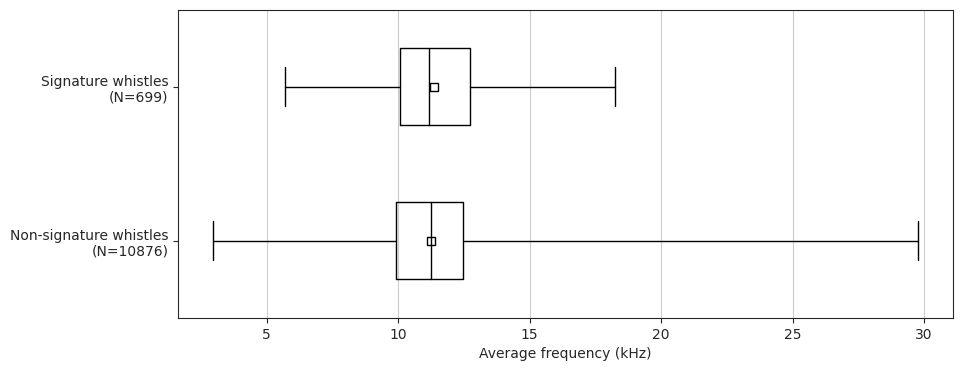

In [21]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(10,4))
box = ax.boxplot(
    x=[wct_average_freq, swt_average_freq],
    widths=0.5, vert=False,
    showfliers=False,
    medianprops=dict(linestyle='solid', color="black"),
    whis=(0, 100)
    )

for i, (line, freqs) in enumerate(zip(box['medians'], [wct_average_freq, swt_average_freq])):
    median_y = (line.get_ydata()[0] + line.get_ydata()[1]) / 2  # Center of the box
    median_x = np.mean(freqs)  # Median value
    plt.plot(
        median_x, median_y, 
        marker='s', markersize=6, markeredgewidth=1,
        markerfacecolor='none', markeredgecolor='black') 

ax.set_yticks(
    [1, 2],
    [
        f"Non-signature whistles\n(N={len(wct_average_freq)})", 
        f"Signature whistles\n(N={len(swt_average_freq)})"
    ]
    )

ax.set_xlabel("Average frequency (kHz)")
ax.xaxis.grid(True)
fig.savefig("/home/loic/Pictures/CDD/boxplot_freq.pdf")
plt.show()
sns.reset_orig()

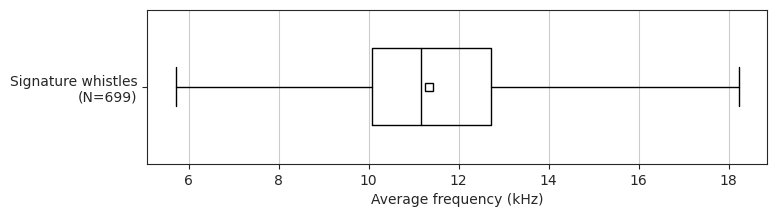

In [22]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(8,2))
box = ax.boxplot(
    x=[swt_average_freq],
    widths=0.5, vert=False,
    showfliers=False,
    medianprops=dict(linestyle='solid', color="black"),
    whis=(0, 100)
    )

for i, line in enumerate(box['medians']):
    mean_y = (line.get_ydata()[0] + line.get_ydata()[1]) / 2  # Center of the box
    mean_x = np.mean(swt_average_freq)  # Mean value
    plt.plot(
        mean_x, mean_y, 
        marker='s', markersize=6, markeredgewidth=1,
        markerfacecolor='none', markeredgecolor='black') 

ax.set_yticks(
    [1],
    [f"Signature whistles\n(N={len(swt_average_freq)})"]
    )
ax.set_xlabel("Average frequency (kHz)")
ax.xaxis.grid(True)
fig.savefig("/home/loic/Pictures/CDD/SWT_boxplot_freq.pdf")
plt.show()
sns.reset_orig()

In [23]:
# SWT average frequency, confidence interval
print("Average frequency (kHz) of SWs:")
print(f"Max: {np.max(swt_average_freq):.2f}")
print(f"75%: {np.quantile(swt_average_freq, 0.75):.2f}")
print(f"Mean: {np.mean(swt_average_freq):.2f}")
print(f"Median: {np.median(swt_average_freq):.2f}")
print(f"25%: {np.quantile(swt_average_freq, 0.25):.2f}")
print(f"Min: {np.min(swt_average_freq):.2f}")

Average frequency (kHz) of SWs:
Max: 18.23
75%: 12.72
Mean: 11.35
Median: 11.17
25%: 10.08
Min: 5.71


### SWTs proportions

Let's investigate if the proportion SWs/whistles varies depeding on our recorded variables.

Why? Because I've seen it here [Janik et al. 1994](http://link.springer.com/10.1007/BF00170704)

In [24]:
results_df["whistle_type"] = None
results_df.loc[results_df[results_df["SWT_[0.2,10]"] == True].index, "whistle_type"] = "Signature"
results_df.loc[results_df[results_df["SWT_[0.2,10]"] == False].index, "whistle_type"] = "Non-signature"
results_df.loc[results_df[results_df["category"] == -1].index, "whistle_type"] = "Singletons"

#### Behavioural state

text '3%' not added for Socialising-Signature


/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:866: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(yorder, va="bottom")
/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:867: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(np.arange(0,101,20))


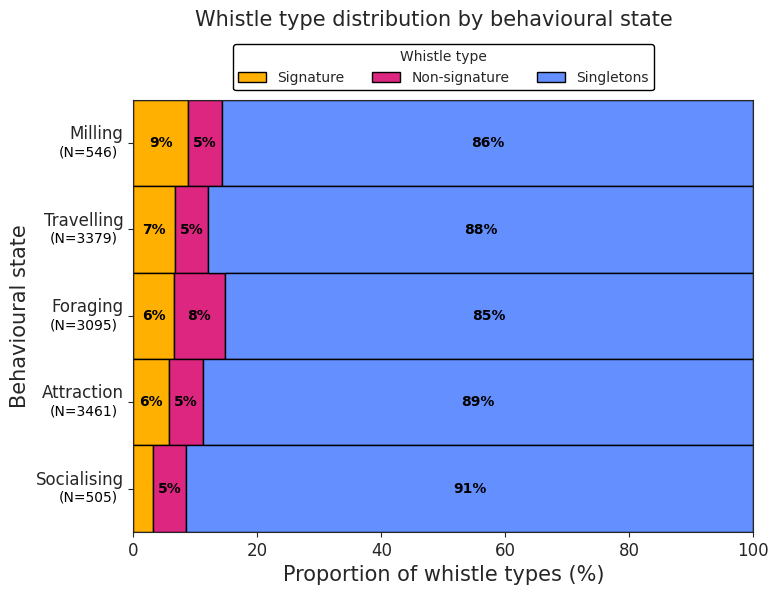

In [25]:
fig_b, axs_b = horizontal_proportion_plot(
    df=results_df, 
    ycol="behaviour", 
    hue="whistle_type", 
    yorder=["Milling", "Travelling", "Foraging", "Attraction", "Socialising"],
    legend_title="Whistle type", 
    ylabel="Behavioural state", 
    xlabel="Proportion of whistle types (%)", 
    maintitle="Whistle type distribution by behavioural state")

axs_b.legend(
    labels=["Signature", "Non-signature", "Singletons"], title="Whistle type",
    frameon=True, framealpha=1, edgecolor="black", fontsize=10,
    bbox_to_anchor=(0.5, 1.075), loc='center', ncol=3)

fig_b.savefig("/home/loic/Pictures/CDD/proportion_behaviours.pdf")
plt.show()
sns.reset_orig()

In [26]:
letter_df = pd.DataFrame(index=["Milling", "Travelling", "Foraging", "Attraction", "Socialising"])
for wtype in ["Signature", "Non-signature", "Singletons"]:
    H0_table = fisher_tests(results_df, 'whistle_type', wtype, 'behaviour', alpha=0.05)
    letters = compact_letter_display(
        [[row["mod_1"], row["mod_2"]] for i, row in H0_table.iterrows() if row["reject_H0"]],
        columns = ["Milling", "Travelling", "Foraging", "Attraction", "Socialising"]
    )
    letter_df[wtype] = letters
print("Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):")
print(letter_df)

Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):
            Signature Non-signature Singletons
Milling             a             a         ab
Travelling         ab             a        acd
Foraging           ab             b        bce
Attraction          b             a        def
Socialising         c             a          f


#### Beacon activation state

text '4%' not added for BEF-Signature


/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:866: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(yorder, va="bottom")
/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:867: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(np.arange(0,101,20))
/tmp/ipykernel_100256/1113003409.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_bea.set_yticklabels(


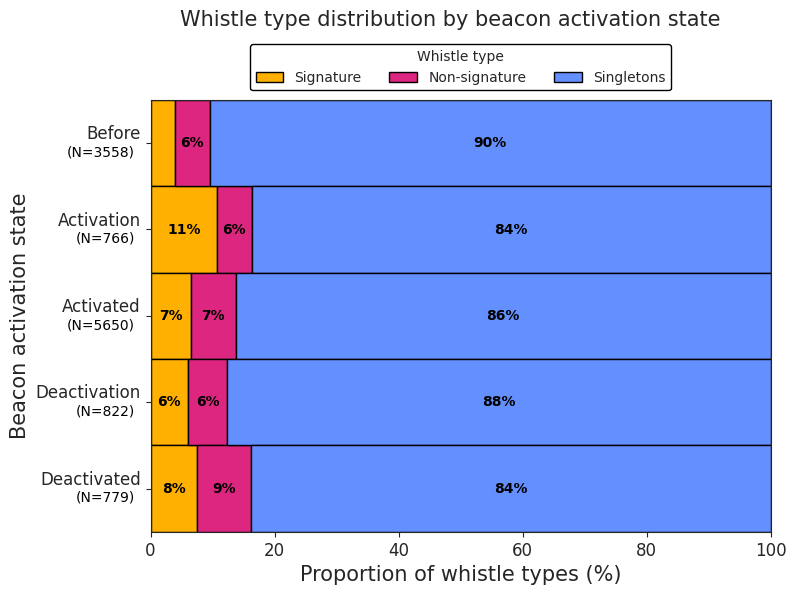

In [27]:
fig_bea, axs_bea = horizontal_proportion_plot(
    df=results_df, 
    ycol="clean_activation_state", 
    hue="whistle_type", 
    yorder=["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"],
    legend_title="Whistle type", 
    ylabel="Beacon activation state", 
    xlabel="Proportion of whistle types (%)", 
    maintitle="Whistle type distribution by beacon activation state")

axs_bea.legend(
    labels=["Signature", "Non-signature", "Singletons"], title="Whistle type",
    frameon=True, framealpha=1, edgecolor="black", fontsize=10,
    bbox_to_anchor=(0.5, 1.075), loc='center', ncol=3)

axs_bea.set_yticklabels(
    ["Before", "Activation", "Activated", "Deactivation", "Deactivated"])
fig_bea.savefig("/home/loic/Pictures/CDD/proportion_beacon.pdf")
plt.show()
sns.reset_orig()

In [28]:
letter_df = pd.DataFrame(index=["Before", "Activation", "Activated", "Deactivation", "Deactivated"])
for wtype in ["Signature", "Non-signature", "Singletons"]:
    H0_table = fisher_tests(results_df, 'whistle_type', wtype, 'clean_activation_state', alpha=0.05)
    letters = compact_letter_display(
        [[row["mod_1"], row["mod_2"]] for i, row in H0_table.iterrows() if row["reject_H0"]],
        columns = ["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"]
    )
    letter_df[wtype] = letters
print("Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):")
print(letter_df)

Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):
             Signature Non-signature Singletons
Before               a             a          a
Activation           b            ab          b
Activated            c            bc         bc
Deactivation         c           abc          c
Deactivated          c             c          b


In [29]:
print("Considerable increase in SW proportion at beacon activation:")
row =  fisher_tests(results_df, 'whistle_type', 'Signature', 'clean_activation_state', alpha=0.05, get_values=True
    )[["mod_1","mod_2","p_value","odds_ratio"]].iloc[0]
print(f"Difference from before to activation: p_value = {row['p_value']:.2e}, odds_ratio = {row['odds_ratio']:.2f}.")

Considerable increase in SW proportion at beacon activation:
Difference from before to activation: p_value = 3.02e-12, odds_ratio = 0.34.


#### Fishing net

/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:866: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(yorder, va="bottom")
/home/loic/Data/DOLPHINFREE/Scripts/SIGWI/WCT_analysis_utils.py:867: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(np.arange(0,101,20))
/tmp/ipykernel_100256/2856851010.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_f.set_yticklabels(


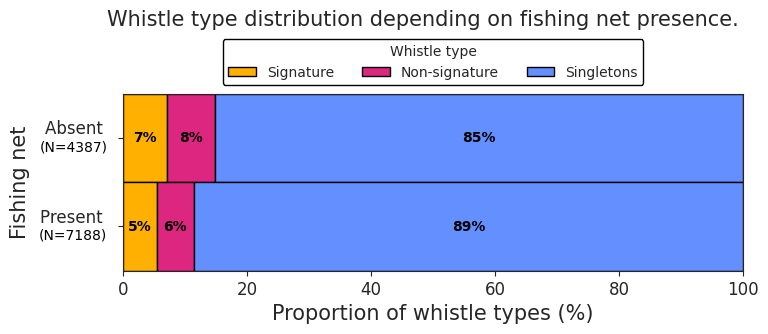

In [30]:
fig_f, axs_f = horizontal_proportion_plot(
    df=results_df, 
    ycol="fishing_net", 
    hue="whistle_type", 
    yorder=["Absent", "Present"],
    legend_title="Whistle type", 
    ylabel="Fishing net", 
    xlabel="Proportion of whistle types (%)", 
    maintitle="Whistle type distribution depending on fishing net presence.")

fig_f.set_size_inches(8,3)
fig_f.subplots_adjust(top=0.7)
axs_f.legend(
    labels=["Signature", "Non-signature", "Singletons"], title="Whistle type",
    frameon=True, framealpha=1, edgecolor="black", fontsize=10,
    bbox_to_anchor=(0.5, 1.18), loc='center', ncol=3)
axs_f.yaxis.set_label_coords(-0.15,0.5)
axs_f.set_yticklabels(
    ["Absent  ", "Present  "])

fig_f.savefig("/home/loic/Pictures/CDD/proportion_net.pdf")
plt.show()
sns.reset_orig()

In [31]:
letter_df = pd.DataFrame(index=["Absent", "Present"])
for wtype in ["Signature", "Non-signature", "Singletons"]:
    H0_table = fisher_tests(results_df, 'whistle_type', wtype, 'fishing_net', alpha=0.05)
    letters = compact_letter_display(
        [[row["mod_1"], row["mod_2"]] for i, row in H0_table.iterrows() if row["reject_H0"]],
        columns = ["Absent", "Present"]
    )
    letter_df[wtype] = letters
print("Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):")
print(letter_df)

Different letters (in each column) indicate different distribution according to Fisher's exact tests (p-value < 0.05):
        Signature Non-signature Singletons
Absent          a             a          a
Present         b             b          b


In [32]:
print("Small decrease in SW proportion when fishing net is present:")
row =  fisher_tests(results_df, 'whistle_type', 'Signature', 'fishing_net', alpha=0.05, get_values=True
    )[["mod_1","mod_2","p_value","odds_ratio"]].iloc[0]
print(f"Difference from before to activation: p_value = {row['p_value']:.2e}, odds_ratio = {row['odds_ratio']:.2f}.")

Small decrease in SW proportion when fishing net is present:
Difference from before to activation: p_value = 3.40e-04, odds_ratio = 1.33.


### Proportion compare stats

In [33]:
print("Showing fisher's exact tests results (upper diagonal: odds ratios, bottom diagonal: p-values)")
pd.options.display.float_format = '{:.2e}'.format

variables = ["behaviour", "clean_activation_state", "fishing_net"]
orders = [
    ["Milling", "Travelling", "Foraging", "Attraction", "Socialising"],
    ["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"],
    ["Absent", "Present"]
]

for variable, order in zip(variables, orders):
    print("")
    H0_table = fisher_tests(results_df, 'whistle_type', "Signature", variable, alpha=0.05, get_values=True)

    diag_table = pd.DataFrame(index=order, columns=order)
    for i in order:
        for j in order:
            if i==j:
                continue
            # find corresponding index in H0_table
            index = [
                idx for idx, row in H0_table.iterrows() if 
                    (
                        ((row["mod_1"]==i) & (row["mod_2"]==j)) or 
                        ((row["mod_1"]==j) & (row["mod_2"]==i))
                    )
                ]
            if len(index) != 1:
                raise ValueError
            diag_table.loc[j, i] = H0_table.loc[index, "odds_ratio"].item()
            diag_table.loc[i, j] = H0_table.loc[index, "p_value"].item()

    display(diag_table)

Showing fisher's exact tests results (upper diagonal: odds ratios, bottom diagonal: p-values)



,Milling,Travelling,Foraging,Attraction,Socialising
Milling,NaN,1.36e+00,1.39e+00,1.59e+00,2.95e+00
Travelling,6.93e-02,NaN,1.02e+00,1.17e+00,2.17e+00
Foraging,5.35e-02,8.41e-01,NaN,1.14e+00,2.12e+00
Attraction,7.18e-03,1.20e-01,1.96e-01,NaN,1.85e+00
Socialising,1.45e-04,1.98e-03,2.39e-03,1.52e-02,NaN


,BEF,BEF+DUR,DUR,DUR+AFT,AFT
BEF,NaN,3.42e-01,5.88e-01,6.32e-01,5.00e-01
BEF+DUR,3.02e-12,NaN,1.72e+00,1.85e+00,1.46e+00
DUR,8.15e-08,5.80e-05,NaN,1.08e+00,8.50e-01
DUR+AFT,9.98e-03,1.00e-03,7.04e-01,NaN,7.90e-01
AFT,3.96e-05,3.41e-02,2.82e-01,2.75e-01,NaN


,Absent,Present
Absent,NaN,1.33e+00
Present,3.40e-04,NaN


### Group size


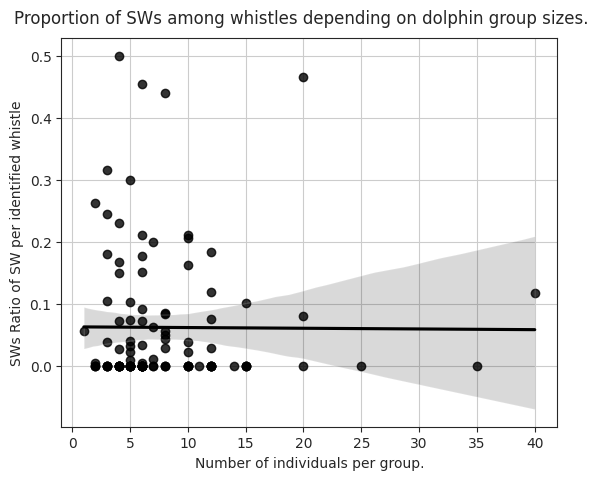

Spearman correlation: -0.04 (p-value 0.70)


In [34]:
ratio_df = results_df.groupby(['sequence', 'group_size'])['is_SW'].mean().reset_index()

sns.set_style("ticks")
fig_size, axs_size = plt.subplots(1,1)
sns.regplot(
    data=ratio_df, x='group_size', y='is_SW',
    scatter=True, ax=axs_size,
    color="black"
)
fig_size.suptitle("Proportion of SWs among whistles depending on dolphin group sizes.")
# fig_size.set_size_inches(2, 6)
fig_size.subplots_adjust(
    top=0.92
)
axs_size.set_xlabel("Number of individuals per group.")
axs_size.set_ylabel("SWs Ratio of SW per identified whistle")
axs_size.xaxis.grid(True)
axs_size.yaxis.grid(True)
# fig_size.savefig("/home/loic/Pictures/CDD/regplot_group_size.pdf")
plt.show()
sns.reset_orig()

r = stats.spearmanr(
    ratio_df["group_size"], 
    ratio_df["is_SW"])

print(f"Spearman correlation: {r[0]:.2f} (p-value {r[1]:.2f})")

No relation between SW proportion and group size. It was expected.